In [1]:
# Cài đặt thư viện Keras (trong trường hợp chưa có sẵn)
!pip install keras

In [43]:
# Import các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt  # Hiển thị ảnh
import matplotlib.image as mpimg
import random
import os
from keras.utils import to_categorical

from keras.preprocessing.image import img_to_array, load_img
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Activation, Flatten
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [44]:
# Tải toàn bộ tập dữ liệu CIFAR-10 (gồm ảnh và nhãn)
(X_all, y_all), _ = cifar10.load_data()


In [45]:
# Chia thủ công 80% train, 20% test
total = X_all.shape[0]
split_index = int(total * 0.8)

X_train = X_all[:split_index]
y_train = y_all[:split_index]
X_test = X_all[split_index:]
y_test = y_all[split_index:]


In [46]:
# ===== 4. TIỀN XỬ LÝ DỮ LIỆU =====
# Chuyển nhãn về dạng 1D
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [47]:
from tensorflow.keras import models, layers, optimizers, callbacks, regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chuẩn hóa hình ảnh
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [48]:
# Khởi tạo ImageDataGenerator với các phép biến đổi dữ liệu
datagen = ImageDataGenerator(
    rotation_range=20,              # Góc xoay ảnh trong khoảng ±20 độ
    width_shift_range=0.2,          # Dịch chuyển ngang ảnh theo chiều rộng, tỷ lệ 20%
    height_shift_range=0.2,         # Dịch chuyển ngang ảnh theo chiều cao, tỷ lệ 20%
    horizontal_flip=True            # Lật ảnh ngang
)

# Áp dụng phương pháp fit để tính toán thống kê bằng cách sử dụng dữ liệu
datagen.fit(X_train)

In [49]:
# One-hot encode nhãn
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


In [50]:
# ===== 5. DANH SÁCH NHÃN CLASS =====
classes = ["airplane", "automobile", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck"]

In [51]:
# ===== 6. HÀM HIỂN THỊ ẢNH MẪU =====
def plot_sample(X, y, index):
    plt.figure(figsize=(3, 3))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])
    plt.show()

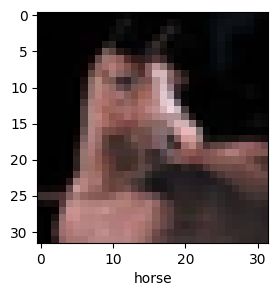

In [52]:
# Ví dụ: hiển thị ảnh thứ
plot_sample(X_train, y_train, 85)

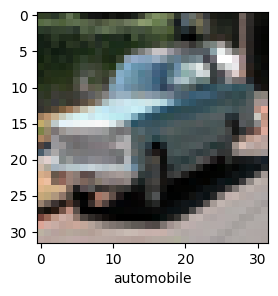

In [53]:
# Ví dụ: hiển thị ảnh thứ
plot_sample(X_train, y_train, 32)

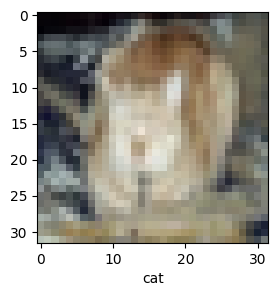

In [54]:
# Ví dụ: hiển thị ảnh thứ
plot_sample(X_train, y_train, 33)

In [62]:
from tensorflow.keras import models, layers, regularizers

cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


In [66]:
# Dùng tf.data.Dataset để tăng tốc xử lý dữ liệu
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(64).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_ds = val_ds.batch(64).prefetch(AUTOTUNE)

# Optimizer AdamW với weight decay
optimizer = optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=1e-5,
    clipvalue=1.0
)

# ReduceLROnPlateau và EarlyStopping callbacks
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Biên dịch mô hình
cnn.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [67]:
# Huấn luyện mô hình
history = cnn.fit(
    train_ds,
    epochs=30,  # Giảm số epochs
    validation_data=val_ds,  # Dùng dataset validation
    callbacks=[early_stopping, lr_scheduler]  # Các callback điều chỉnh học
)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4291 - loss: 2.0785 - val_accuracy: 0.5330 - val_loss: 1.6189 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5820 - loss: 1.4750 - val_accuracy: 0.6679 - val_loss: 1.1905 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6350 - loss: 1.2793 - val_accuracy: 0.6567 - val_loss: 1.2178 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6665 - loss: 1.1847 - val_accuracy: 0.7046 - val_loss: 1.0993 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6870 - loss: 1.1429 - val_accuracy: 0.6850 - val_loss: 1.1783 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7005 - loss: 1.1161 - val_accuracy: 0.7097 - val_loss: 1.1077 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7186 - loss: 1.0822 -

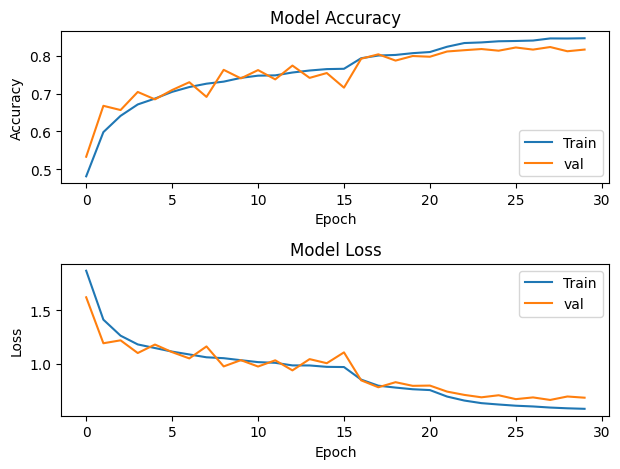

In [73]:
# Vẽ đồ thị accuracy và loss
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper right')
plt.tight_layout()
plt.show()

In [74]:
cnn.save('model.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


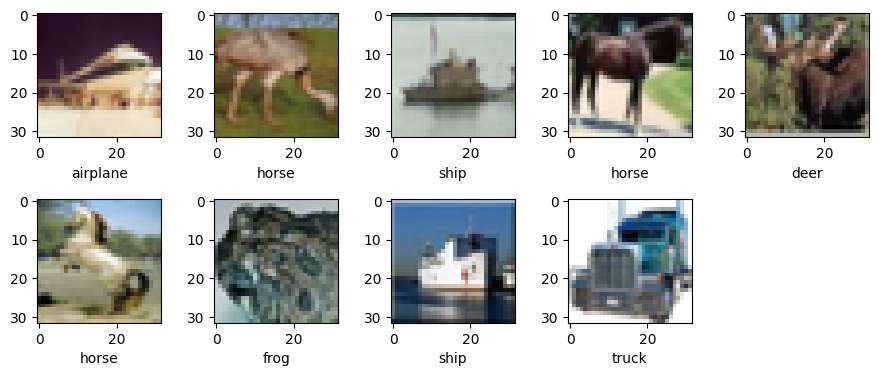

In [75]:
# Hiển thị ngẫu nhiên 9 tấm hình trong tập test và dự đoán
#Hàm này để chọn ngẫu nhiên các tấm ảnh trong tập dữ liệu
import random
import os
predicted_classes=cnn.predict(X_test)
plt.rcParams['figure.figsize']=(9,9)
for i in range(9):
  plt.subplot(5,5,i+1)
  num=random.randint(0,len(X_test))
  plt.imshow(X_test[num])
  y_classes = [np.argmax(element) for element in predicted_classes]
  plt.xlabel(classes[y_classes[num]])
plt.tight_layout()

Chọn 1 hình ảnh để dự đoán:


Saving tải xuống (7).jpg to tải xuống (7) (1).jpg


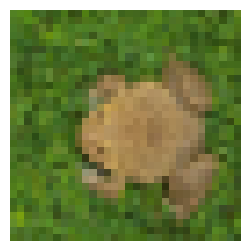

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
Dự đoán hình ảnh: frog với độ chính xác: 91.10%


In [76]:
from google.colab import files
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Hàm tải hình ảnh từ tệp được chọn và hiển thị lên giao diện người dùng
def load_and_predict():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_test = load_image(io.BytesIO(uploaded[filename]))
        plt.figure(figsize=(3, 3))  # Đặt kích thước hình ảnh hiển thị
        plt.imshow(img_test[0])
        plt.axis('off')
        plt.show()
        ob = cnn.predict(img_test)
        prediction = np.argmax(ob)
        confidence = np.max(ob) * 100  # Tính xác suất dự đoán chính xác
        print(f'Dự đoán hình ảnh: {classes[prediction]} với độ chính xác: {confidence:.2f}%')

# Hàm để load và chuẩn bị hình ảnh
def load_image(image_bytes):
    image = Image.open(image_bytes)
    image = image.resize((32, 32))
    image = np.expand_dims(image, axis=0)
    image = np.array(image)
    img = image.astype('float32')
    img = img / 255.0
    return img

# Biến classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Tạo nút để chọn hình ảnh và dự đoán
print("Chọn 1 hình ảnh để dự đoán:")
load_and_predict()